In [1]:
import scniche as sn
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Last run with scNiche version:", sn.__version__)

# set seed
sn.pp.set_seed()

/slurm/home/yrd/fanlab/qianjingyang/.conda/envs/scniche_v101/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Last run with scNiche version: 1.1.0


In [2]:
# download data from figshare (https://figshare.com/ndownloader/files/50251680)
# adata = sn.datasets.mouse_aging_merfish()
adata = sc.read('MERFISH_Aging.h5ad')
len(set(adata.obs['slice_id']))

31

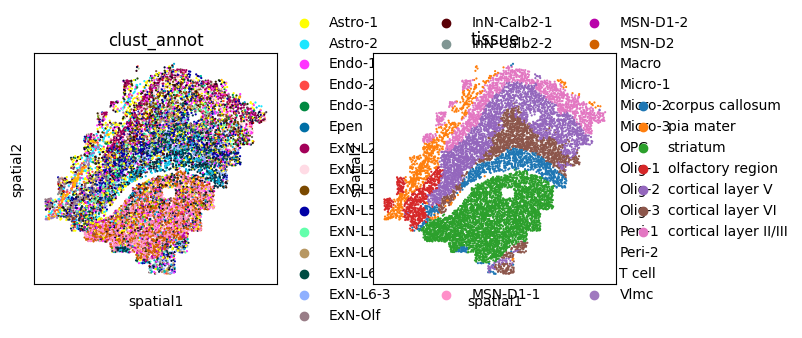

In [3]:
# MsBrainAgingSpatialDonor_7-1 as an example
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata[adata.obs['slice_id'] == 'MsBrainAgingSpatialDonor_7-1'], basis="spatial", color=['clust_annot', 'tissue', ],s=10, )

In [4]:
celltype_key = 'clust_annot'
sample_key = 'slice_id'
use_rep = 'X_pca' # the original authors already normalize and scale, the data, as well as perform PCA
k_cutoff = 30
batch_num = 100
epochs = 100


# prepare multi slices
adata = sn.pp.process_multi_slices(
    adata=adata,
    celltype_key=celltype_key,
    sample_key=sample_key,
    mode='KNN',
    k_cutoff=k_cutoff,
    is_pca=False,
    verbose=False,
    layer_key=use_rep
)
adata = sn.pp.prepare_data_batch(adata=adata, verbose=False, batch_num=batch_num)

# training
model = sn.tr.Runner_batch(adata=adata, device='cuda:0', verbose=False)
adata = model.fit(lr=0.01, epochs=epochs)

# clustering
target_num = len(set(adata.obs['tissue']))
adata = sn.tr.clustering(adata=adata, target_k=target_num)

-------Process 31 slices...


100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Applying K-Means Clustering with 7 target cluster numbers...


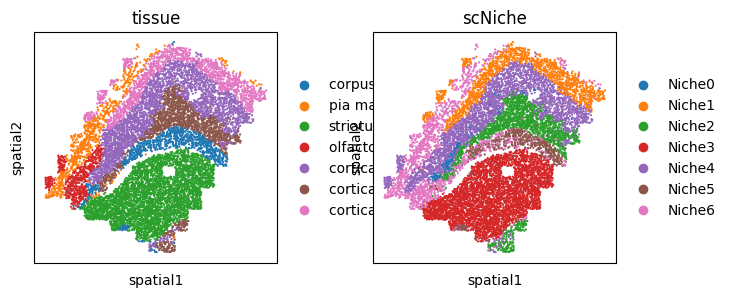

In [5]:
# MsBrainAgingSpatialDonor_7-1 an example
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata[adata.obs['slice_id'] == 'MsBrainAgingSpatialDonor_7-1'], basis="spatial", color=['tissue', 'scNiche'],s=10, )

In [7]:
dataset_list = []
ari_list = []
sample_list = sorted(list(set(adata.obs['slice_id'])))
res = adata.obs.copy()

for i in sample_list:
    res_tmp = res.loc[res['slice_id'] == i]
    a = res_tmp['tissue'].values
    b = res_tmp['scNiche'].values
    # ari
    ari_tmp = adjusted_rand_score(a, b)
    
    dataset_list.append(i)
    ari_list.append(ari_tmp)

eva_df = pd.DataFrame({'Dataset': dataset_list, 'ARI': ari_list, })

print(f"Mean ARI: {np.mean(eva_df.ARI)}; Median ARI: {np.median(eva_df.ARI)}")

Mean ARI: 0.7330050529254917; Median ARI: 0.7302111641338843
